In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import argrelextrema

import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
#jtplot.style(theme='solarizedd', context='notebook', ticks=True, grid=False)
torch.set_num_threads(4)
np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:5'

FREERUN = 20  # Extra predicition time-steps after test data
deltaT = .02      # Number of extra free-running steps  int(20/.02) 

rho = 28.0
sigma = 10.0
beta = 8/3

# Lorenz 1963
def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]             # Initial point
t = np.arange(0,300+FREERUN,deltaT)  # Total of 320 full steps with deltaT=.02
states = odeint(f,state0,t)

mu = np.mean(states, axis=0)       # Get mean for each of x,y,z
signal = (states - mu)[:,[0,1,2]]  # Mean center the data
M = signal.shape[0] - int(FREERUN/deltaT)  # Length of train plus test... no freerun
K = 3                                  # Input dimension
L = 3                                  # Output dimension
RF = .5                                # For feedback <--- not implemented
TEST = 1000                            # length of test
LEAD = 100                            # Number of points to plot before test
BURNIN = 100                           # Number of steps ignored for random x0 to fade
REG = 1e-8                             # Regularization factor for ridge regression
TRAINLENGTH = M-TEST    

MINMAXS = np.max(signal[:TRAINLENGTH+TEST],axis=0)-np.min(signal[:TRAINLENGTH+TEST],axis=0)
STD = np.std(signal[:TRAINLENGTH+TEST],axis=0)
RGS = [(-19.5,19.5),(-27,27),(-25,25)]
BINS = 50

print(f'Signal length M={M}')
print(f'Normalizing value MM is {MINMAXS}')
print(f'std = {STD}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000
Normalizing value MM is [38.05303465 52.5343247  46.87228953]
std = [7.9122292  8.99288317 8.56681415]


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

## Training Loop for gp_minimize

In [3]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)
    


In [ ]:
#min_a, max_a = .57, .6
#min_sr, max_sr = 5.3, 5.4
#min_g, max_g = .2, .24
#min_ri, max_ri = .17, .2
#min_rr, max_rr = 2.65, 2.7

min_a, max_a = .5, .9
min_sr, max_sr = 1.1, 1.7
min_g, max_g = .2, .24
min_ri, max_ri = .01, .1
min_rr, max_rr = .85, 2.7
space = [Real(min_a, max_a, name='a'),
         Real(min_sr, max_sr, name='sr'),
         Real(min_ri, max_ri, name='ri'),
         Real(min_rr, max_rr, name='rr')
        ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,ri=1.0,rr=1.0):
    start = time.time()
    amp = 1.
    global running_error, s, counter, signal, N, ref, rn, \
           alphas, rhos, gammas, inScales, dict_model, \
           model_counter, error_per_N, error_over_N, best_N_model
    
    # Avoid copying from CPU to GPU    
    # Init container variables directly on GPU
    ut = torch.zeros((K,1),dtype=dtype, device=torch.device(DEVICE)) 
    tp = torch.zeros((K,1),dtype=dtype, device=torch.device(DEVICE))
    
    # Init matrices directly on GPU
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1) # Concat to one matrix for faster compute
    xt, yt = set_vectorsGPU(N,L,rr) # On GPU random init x0 and container yt   
    
    # GPU containers for Phi and y in regression solve (bad naming... reused var name)
    # Here states is the Phi matrix
    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                        device=DEVICE)
    # Loop through training data and accumulate states for ridge-regression solve
    for i in range(TRAINLENGTH):
        ut[:,0] = s[i]                         # Forcing u[t] 
        tp[:,0] = s[i+1]                       # True target for prediction u[t+1] 
        uxy = torch.cat((ut,xt,yt),0)          # Concat vectors for use with Wnet
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp) # x[t+1] = F(x[t],u[t])
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE) # Transpose as row for Phi
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy() 
    #target = targets.detach().cpu().numpy()
    
    
    ############################             Ridge Regression solve on CPU (fast!)
    torch.cuda.synchronize()    # GPU threads were running asynchronous
                                # Use signal since already sitting on CPU side
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
                                # Move back to GPU
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE) # Trained Wout
    torch.cuda.synchronize()    # Make sure synchronized before prediction pass
    ############################
    
    # Container for all predictions... Burnin --> train --> test --> freerun
    predictions = torch.zeros((M+int(FREERUN/deltaT),K),
                              dtype=dtype,
                              device=torch.device(DEVICE))
    # Reset new initial vectors for prediction pass
    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/deltaT)):
        if(i < TRAINLENGTH):
            ut[:,0] = s[i]
        else:
            #pdb.set_trace()
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        #pdb.set_trace()
        predictions[i] = yt1[:,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()  # Move predictions onto CPU (numpy)
    
    nrmse3D = np.ones((K,1))*1000
    try:
        for i in range(K):
            nrmse3D[i,0] = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST,i],
                                   yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST,i],
                                   MINMAXS[i])
    except: 
        pass
    #### Pearson Correlation <=> Cosine Distance    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST]
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST])
    dists = np.zeros(K)
    for i in range(K):
        avec = av[:,i].reshape(TEST,1)
        bvec = bv[:,i].reshape(TEST,1)
        num = np.squeeze(np.dot(avec.T,bvec))
        den = np.linalg.norm(avec)*np.linalg.norm(bvec)
        cosine_similarity = num/den
        cosine_distance = 1 - cosine_similarity
        dists[i] = cosine_distance
    dist = np.max(dists)
    nrmse = np.max(nrmse3D)
    loss = np.max(nrmse3D+dists)
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) and (nrmse < .3)):
        print(f'Dist {dist:3f}')
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        if(error_over_N > running_error):
            print('\n\nNew N best!!!!!!!!!!!!\n\n')
            error_over_N = running_error  #set the lowest error
            best_N_model = [N,ref,rn,counter]
            states_dict = {'States': state}
            with open(f'Dicts/States/states_L3D_{N}.json', 'w') as fp:
                json.dump(states_dict, fp, cls=NumpyArrayEncoder)
            dict_model[str(N)] = {'Wnet': wnet,
                                  'Wout': wout,
                                  'Preds': yHat_GPU,
                                  'Params': currentParams}
            print(best_N_model)
        
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
                
        fig = plt.figure(figsize=(15,12))
        plt.subplot(3,1,1)
        plt.plot(signal[TRAINLENGTH-LEAD:,0], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,0], label='X pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.subplot(3,1,2)
        plt.plot(signal[TRAINLENGTH-LEAD:,1], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,1], label='Y pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.subplot(3,1,3)
        plt.plot(signal[TRAINLENGTH-LEAD:,2], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,2], label='Z pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        plt.show()
        plt.close()
        model_counter += 1
        error_per_N.append(nrmse3D)

        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {np.max(nrmse):.3f} CD {np.max(dists):.3f}')
    counter += 1
    return loss

## Parameter Search with gp_minimize

In [ ]:

CALLS = 100      
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped N=1000,900,800
size = [300,50,40,30,20,10]
rand_state = [11,37,3,24,91]

dict_counters = {}
dict_model = {}
for N in size:
    model_counter = 0
    error_per_N =  []
    best_N_model = [N,0,0,0] 
    
    min_a, max_a = .5, .9
    min_sr, max_sr = 1.1, 1.7
    min_g, max_g = .2, .24
    min_ri, max_ri = .01, .1
    min_rr, max_rr = .85, 2.7

    space = [Real(min_a, max_a, name='a'),
             Real(min_sr, max_sr, name='sr'),
             Real(min_ri, max_ri, name='ri'),
             Real(min_rr, max_rr, name='rr')
            ]
    error_over_N = 1000
    for ref in range(5):
        
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            start = time.time()
            running_error = 1000
            counter = 0 
            print(f'********** Size{N} ref {ref} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            end = time.time()-start
            print(f'End Refinement Run {ref} Time {end:.3f}')
            print(f'\nRun: {rn} Best result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        
        
    print(model_counter)
    print(np.mean(np.array(error_per_N),axis=0))
    if(model_counter == 0):
        dict_counters[f'{str(N)}'] = {'numModels': model_counter,
                                      'meanError': [np.nan,np.nan,np.nan],
                                      'varError' : [np.nan,np.nan,np.nan]}
    else:
        print(np.mean(np.array(error_per_N),axis=1))
        dict_counters[f'{str(N)}'] = {'numModels': model_counter,
                                      'meanError': np.mean(np.array(error_per_N),axis=0).tolist(),
                                      'varError' : np.var(np.array(error_per_N),axis=0).tolist()}
    with open('Dicts/diag_L3D.json', 'w') as fp:
        json.dump(dict_counters, fp, cls=NumpyArrayEncoder)
    with open('Dicts/models_L3D.json', 'w') as fp:
        json.dump(dict_model, fp, cls=NumpyArrayEncoder)
print(dict_counters)

### Analysis

In [4]:
fpath = 'Dicts/diag_L3D.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/models_L3D.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

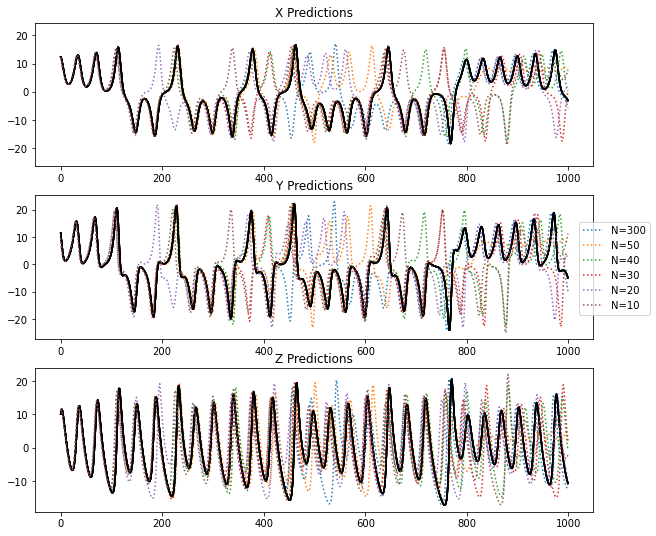

In [5]:
size = [300,50,40,30,20,10]
variable = ['X','Y','Z']

fig, ax = plt.subplots(3, figsize=(10,9))
for sp in range(3):
    ax[sp].set_title(f'{variable[sp]} Predictions')
    for n in size:
        preds = np.array(dict_models[str(n)]['Preds'])
        ax[0].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST,sp], color='k',
                  label='target', alpha=0)
        if(sp==2):
            ax[sp].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST,sp], color='k')
            ax[sp].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST,sp],
                     linestyle='dotted', label=f'N={n}')
        else:
            ax[sp].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST,sp], color='k')
            ax[sp].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST,sp],
                     linestyle='dotted')
plt.legend(bbox_to_anchor=(1.11, 2.05))
plt.show()

### Get rank

Alpha 0.6175128539053444 --- Gamma 1.0
Ave rank for N=300 is 124 Tolerance 1e-24 Rho A 0.805
Alpha 0.5163718946188633 --- Gamma 1.0
Ave rank for N=50 is 37 Tolerance 1e-15 Rho A 0.998
Alpha 0.7125842814257909 --- Gamma 1.0
Ave rank for N=40 is 21 Tolerance 1e-29 Rho A 0.832
Alpha 0.653803735222547 --- Gamma 1.0
Ave rank for N=30 is 17 Tolerance 1e-29 Rho A 0.853
Alpha 0.6112661373460827 --- Gamma 1.0
Ave rank for N=20 is 10 Tolerance 1e-29 Rho A 0.681
Alpha 0.6883840654150684 --- Gamma 1.0
Ave rank for N=10 is 2 Tolerance 1.0 Rho A 0.718


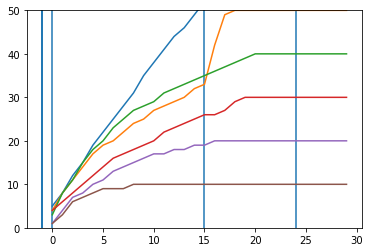

In [6]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

K = 1
L = 1
tols = [1/10**x for x in range(0,30)]
plt.figure()
for n in size:
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    print(f'Alpha {a} --- Gamma {g}')
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    v = np.argmax(np.gradient(rkc))-1
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50)
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Ave rank for N={n} is {ave_rank} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
plt.ylim(0,50)
plt.show()

### Get Divergence

In [7]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

No handles with labels found to put in legend.
No handles with labels found to put in legend.


k-size=30 Trainingset min=0.977  threshold=0.928  Location=313
k-size=30 Trainingset min=0.933  threshold=0.886  Location=309
k-size=30 Trainingset min=0.965  threshold=0.917  Location=302


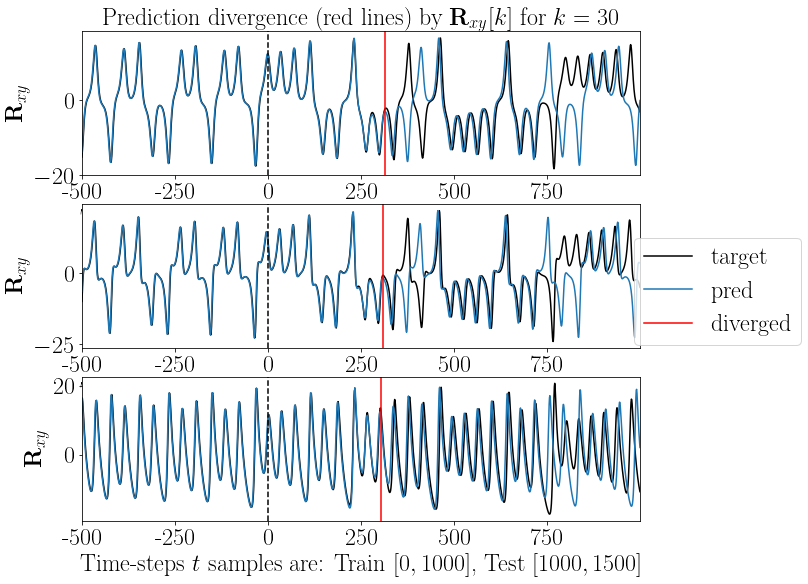

In [8]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

start = TRAINLENGTH - 1000
stop = M+FREERUN
k_list = [30]
fig, ax = plt.subplots(3, figsize=(10,9))
for sp in range(3):
    for k in k_list:
        lengthTC = (stop-start)-k
        trainCorr = np.zeros(lengthTC) # 21000-k
        pred = np.array(dict_models[str(k)]['Preds'])
        for j in range(start,stop-k):
            tar = signal[j:j+k,sp].reshape((k,1))
            prd = pred[j:j+k,sp].reshape((k,1))
            trainCorr[j-start] = Rxy(tar,prd)
        minVal = trainCorr[:1000].min()
        threshold = minVal*.95
        thresholdLoc = np.where(trainCorr[1000:]<threshold)[0][0]
        print(f'k-size={k} Trainingset min={minVal.round(3)}  threshold={threshold:.3f}',
              f' Location={thresholdLoc}')
        #ax[sp].plot(trainCorr[500:1300], color='r', label=f'k={k}')
    ax[sp].plot(signal[TRAINLENGTH-500:TRAINLENGTH+TEST,sp], color='k', label='target')
    ax[sp].plot(pred[TRAINLENGTH-500:TRAINLENGTH+TEST,sp], label='pred')
    ax[sp].axvline(500+thresholdLoc,color='r', label='diverged')
    ax[sp].axvline(500,color='k',linestyle='dashed')
    ax[sp].set_ylabel('$\mathbf{R}_{xy}$')
    ax[sp].set_xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
    ax[sp].set_xticklabels([-500,-250,0,250,500,750])
    plt.legend(fontsize=24,bbox_to_anchor=(1.31, 2.05))
    ax[0].set_title('Prediction divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=30$')
plt.show()